# Mutual Information

Mutual Information can be used for features selection. It is a great way of detecting non-linear relationship between
input and output of the data.

```
feature_selection.mutual_info_classif(X, y)	Estimate mutual information for a discrete target variable.
feature_selection.mutual_info_regression(X, y)	Estimate mutual information for a continuous target variable.
```

Have joint pmf -> be able to sum out certain variables to get the pmf for the variable alone.


$I(X,Y) = H(X) + H(Y) - H(X,Y)$




In [1]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, chi2
from sklearn.preprocessing import OneHotEncoder

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import pshape
from matplotlib import colors
from utils.plots import plot_dist
import pandas as pd

In [3]:
# making a joint table
def joint(X, cols=None):
    """
    create joint pmf 
    X: samples (n_samples, n_feats)
    cols: names/aliases of column features [optional]
    """
    values, counts = np.unique(ar=X,
                          return_counts=True,
                          axis=0)

    probs = counts/np.sum(counts)
    if cols is None:
        cols = [f"rv{i}"for i in range(values.shape[-1])]
        
    pmf = pd.DataFrame(values, columns=cols)
    pmf["p"] = probs
    pmf = pmf.sort_values('p',ascending=False)
    return pmf

def h(df):
    """
    entropy using log base 2
    """
    p = df["p"]
    return (-1)*np.sum(p*np.log2(p))

def marg(pmf, var):
    """
    var is a list of variable names
    sum out variables
    """
    a = pmf[[*var,"p"]].groupby(var,as_index=False).sum()
    return a

In [4]:
X = np.random.binomial(1,.7,(100,2))
pmf = joint(X)
rv0 = marg(pmf,["rv0"])
rv1 = marg(pmf,["rv1"])
rv01 = marg(pmf,["rv0", "rv1"])
rv1["p"].sum()
pmf

,rv0,rv1,p
3,1,1,0.50
1,0,1,0.24
2,1,0,0.17
0,0,0,0.09


In [5]:
m01 = marg(pmf, ["rv0","rv1"])
m0 = marg(pmf, ["rv0"])
m1 = marg(pmf, ["rv1"])
mi = h(m1) + h(m0) - h(m01)
mi


0.0002975837004262072

array([0.00316716])

In [31]:
def plot_mi(X,y):
    mi = mutual_info_classif(X,y, discrete_features=True)
    figsize=(20,5)
    plt.figure(figsize=figsize)
    plt.imshow(np.array([mi]),aspect=20*figsize[1]/figsize[0], vmin=0,vmax=np.max(mi))
    plt.colorbar()
    plt.show()
    
    figsize=(20,5)
    plt.figure(figsize=figsize)
    plt.plot(mi)
    plt.show()

In [32]:
def dist(a, plot=True):

    v,c = np.unique(a.flatten(),return_counts=True)
    c = c/np.sum(c)

    if plot:
        plt.stem(v,c, use_line_collection=True,markerfmt="x",basefmt=".")
        plt.grid()
        plt.show()
    
    
    return v,c

def dists(*args):
    for a in args:
        _ = dist(a)

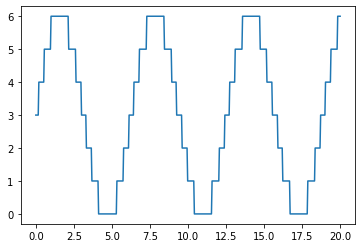

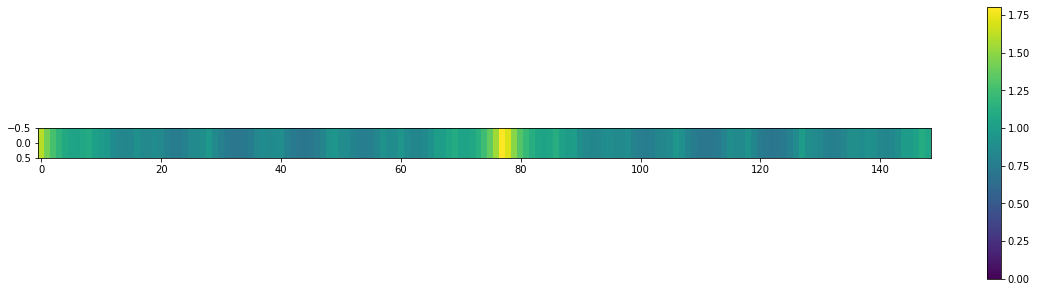

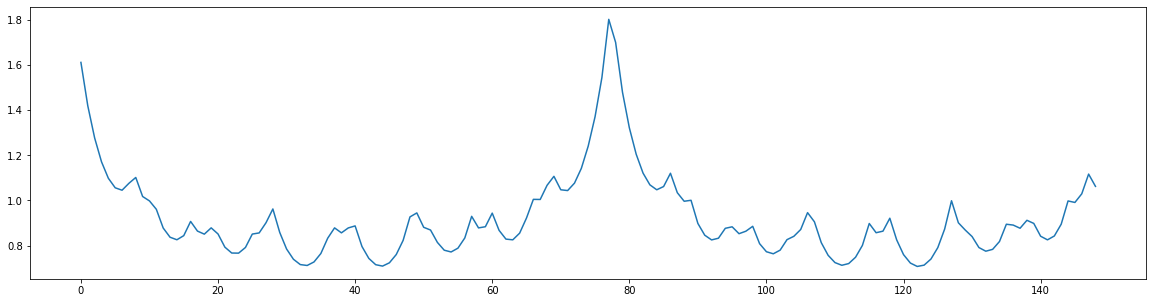

In [42]:
x = np.linspace(0,20,500)
y = np.round(3*np.sin(x)+3)
plt.plot(x,y)
X = sequencify(y,seq_len=150)
plot_mi(X[:,1:],X[:,0])


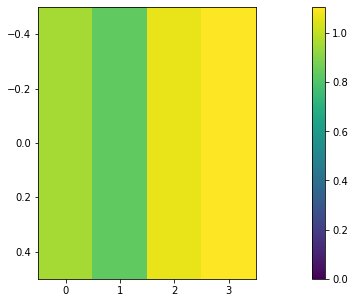

In [7]:
# squeeze into (N,1,L)
# get MI for each L give the past n steps.



In [43]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer, get_data_sub_paths, pshape, get_data_resolutions
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup

from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models,\
                                get_models_metrics, get_models_results
from pprint import pprint
from time import time

In [155]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))
data_sub_path = 'T24H-X255M-Y220M_2013-01-01_2017-01-01'


array(['T12H-X850M-Y880M_2013-01-01_2017-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2017-01-01',
       'T24H-X255M-Y220M_2013-01-01_2017-01-01',
       'T24H-X425M-Y440M_2013-01-01_2017-01-01',
       'T24H-X850M-Y880M_2013-01-01_2017-01-01',
       'T24H-X85M-Y110M_2013-01-01_2017-01-01',
       'T3H-X850M-Y880M_2013-01-01_2017-01-01',
       'T6H-X850M-Y880M_2013-01-01_2017-01-01'], dtype='<U39')


In [156]:
conf = BaseConf()

conf.use_historic_average = True 
conf.use_classification = True
conf.use_crime_types = True

conf.seed = 3#int(time())  # idea is to have a constant seed while changing hyper parameters

conf.pad_with = 1 
conf.seq_len = 1

conf.model_name = f"Mutual Info"

conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path,
              log_config='./logger/standard_logger_config.json',
              default_level=log.INFO)

# SET NUMPY AND TORCH SEEDS LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")

conf.device = device

# SET THE HYPER PARAMETERS
conf.resume = False
conf.early_stopping = False
conf.max_epochs = 120
conf.dropout = 0#0.2
conf.weight_decay = 0#1e-8
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 4e-3
conf.batch_size = 64

# CRIME DATA
conf.sub_sample_test_set = 0
conf.sub_sample_train_set =  0 # 0 #
conf.sub_sample_validation_set = 0 # 0 #

2019-12-01T21:47:56 | root | INFO | Device: cpu


```
data_group = CellDataGroup(data_path=conf.data_path, conf=conf)
loaders = CellDataLoaders(data_group=data_group, conf=conf)
conf.freqstr = data_group.t_range.freqstr  

def get_input_features(batch_loader, conf):
    probas_pred = np.zeros(batch_loader.dataset.target_shape, dtype=np.float)
    y_true = batch_loader.dataset.targets[-len(probas_pred):]
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]

    with torch.set_grad_enabled(False):
        model.eval()

        num_batches = batch_loader.num_batches
        for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
            current_batch = batch_loader.current_batch
            
            # reformat for model input
            tmp_feats = np.swapaxes(tmp_feats,0,1)
            tmp_feats = np.reshape(tmp_feats, (tmp_feats.shape[0],-1))
            spc_feats = spc_feats[-1]
            env_feats = env_feats[-1]
            cmp_feats = np.concatenate((spc_feats,tmp_feats,env_feats),axis=-1)
            targets = targets[-1, :, 0]                        

            # Transfer to PyTorch Tensor and GPU
            cmp_feats = torch.Tensor(cmp_feats).to(conf.device)
                                     
            # used for log_reg_3
            spc_feats = torch.Tensor(spc_feats).to(conf.device)  
            tmp_feats = torch.Tensor(tmp_feats).to(conf.device)  
            env_feats = torch.Tensor(env_feats).to(conf.device)  

            out = model(cmp_feats)
#             out = model(tmp_feats)
#             out = model(env_feats)
#             out = model(spc_feats=spc_feats,
#                         tmp_feats=tmp_feats,
#                         env_feats=env_feats)
            
            if conf.use_classification:
                batch_probas_pred = F.softmax(out, dim=-1)[:, 1].cpu().numpy()  # select class1 prediction
            else:
                batch_probas_pred = out.cpu().numpy()

            for i, p in zip(indices, batch_probas_pred):
                n, c, h, w = i
                probas_pred[n, c, h, w] = p

    return y_true, probas_pred, t_range
    
    
```    

In [157]:
from utils.preprocessing import Shaper
from utils.data_processing import sequencify
from models.baseline_models import HistoricAverage

In [158]:
def describe(*A):
    for a in A:
        v,c = dist(a)
        d = {
            "min":np.min(a),
            "max":np.max(a),
            "mean":np.mean(a),
            "std":np.std(a),
            "median":np.median(a),
            "nunique":len(np.unique(a)),
            "shape":np.shape(a),
            "dist": dict(
                zip(v,c))
        }

        pprint(d)
        print("____________________________________________________________")

In [159]:
conf.use_crime_types=False

with np.load(conf.data_path + "generated_data.npz") as zip_file:  # context helper ensures zip_file is closed
    if conf.use_crime_types:
        crimes = zip_file["crime_types_grids"]
    else:
        crimes = zip_file["crime_grids"]
        
print(conf.data_path)        

./data/processed/T24H-X255M-Y220M_2013-01-01_2017-01-01/


fitted historic average: step (1) and max_steps (-1)


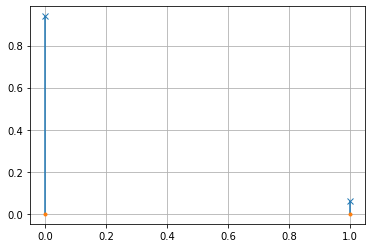

{'dist': {0.0: 0.939255177486042, 1.0: 0.06074482251395792},
 'max': 1.0,
 'mean': 0.06074482251395792,
 'median': 0.0,
 'min': 0.0,
 'nunique': 2,
 'shape': (1461, 1, 8681),
 'std': 0.23886165253490524}
____________________________________________________________


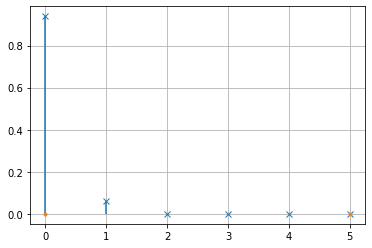

{'dist': {0.0: 0.939255177486042,
          1.0: 0.05998726951422387,
          2.0: 0.0007511664684082343,
          3.0: 5.1249942738044746e-06,
          4.0: 8.673067232592188e-07,
          5.0: 3.942303287541904e-07},
 'max': 5.0,
 'mean': 0.06151041781239856,
 'median': 0.0,
 'min': 0.0,
 'nunique': 6,
 'shape': (1461, 1, 8681),
 'std': 0.24347127449178935}
____________________________________________________________


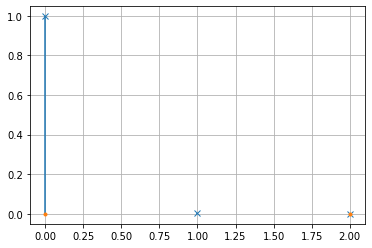

{'dist': {0.0: 0.9976054449831471,
          1.0: 0.0023940819404584474,
          2.0: 4.7307639450502846e-07},
 'max': 2.0,
 'mean': 0.0023950280932474575,
 'median': 0.0,
 'min': 0.0,
 'nunique': 3,
 'shape': (1461, 1, 8681),
 'std': 0.04889006122382167}
____________________________________________________________


In [160]:
log_floor_crimes = np.floor(np.log2(1 + crimes))

conf.shaper_threshold = 0
conf.shaper_top_k = -1

shaper = Shaper(data=log_floor_crimes,
                conf=conf)
X_reg = shaper.squeeze(log_floor_crimes)  # crime counts scaled and discretised

X_clf = np.copy(X_reg) # crime=1 no_crime=0
X_clf[X_clf > 0] = 1

max_steps = -1


ha = HistoricAverage()
ha.fit(X_reg)
ha.max_steps = max_steps
X_ha = ha.transform(X_reg)

X_reg = X_reg[max_steps+1:]

X_clf = X_clf[max_steps+1:]

X_ha = X_ha[max_steps+1:]
X_ha = np.round(X_ha)  # ensures we still work in discrete values

sorted_indices = np.argsort(X_reg[:,0].mean(0))[::-1]

describe(X_clf,X_reg,X_ha)

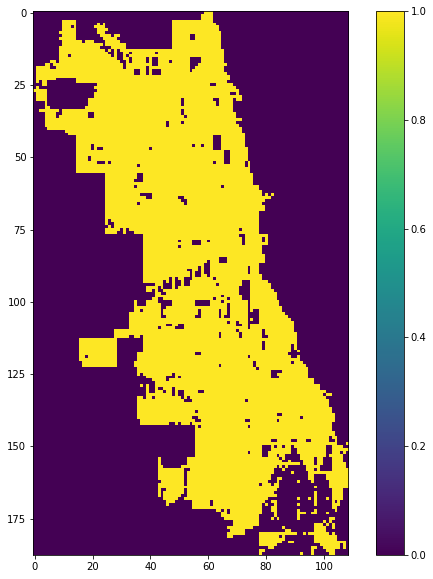

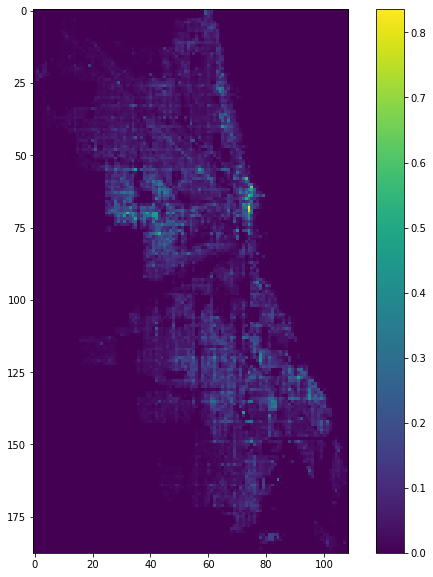

In [161]:
xx = X_clf

im(shaper.unsqueeze(xx).max(0)[0])
im(shaper.unsqueeze(xx).mean(0)[0])

In [162]:
mis_t = []

for offset in range(1,28):
    mis = []
    for i in range(X_clf.shape[-1]):
        X = np.reshape(X_clf[:-offset,0,i].flatten(),(-1,1))
        y = X_clf[offset:,0,i].flatten()

        mi = mutual_info_classif(X,y,discrete_features=True) # uses log not log2
        mis.append(mi)
    mis_t.append(mis)
    
mis_t = np.array(mis_t)[:,:,0]    

In [163]:
new_mis_grid = np.zeros((mis_t.shape[0]+1,mis_t.shape[1]+1))

new_mis_grid[0,1:] = mis_t.mean(0)
new_mis_grid[1:,0] = mis_t.mean(1)
new_mis_grid[1:,1:] = mis_t

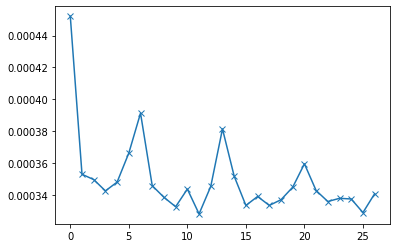

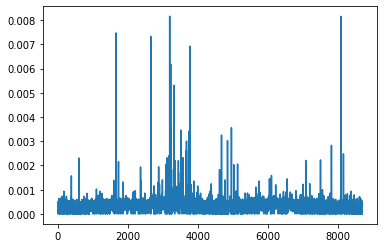

In [164]:
plt.plot(mis_t.mean(1),marker="x")
plt.show()
plt.plot(mis_t.mean(0))
plt.show()

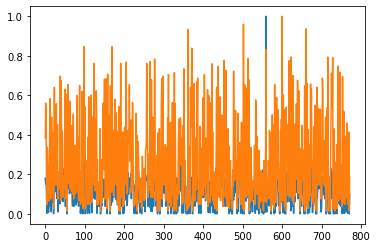

In [165]:
lim = 1000

plt.plot(norm_max(mis_t.mean(0)[top_mi[:lim]]))
plt.plot(norm_max(entropy(X_clf.mean(0)[0,top_mi[:lim]])))

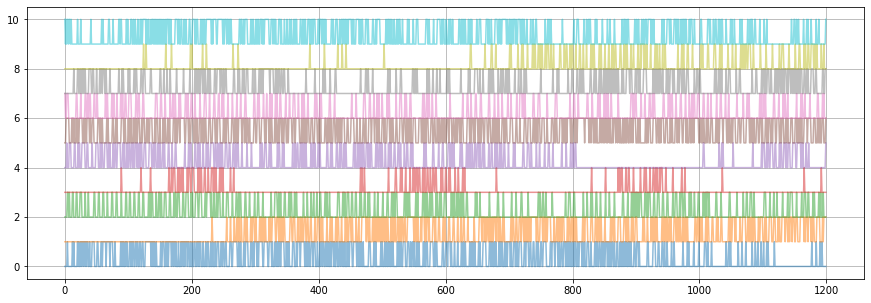

In [169]:
top_mi = np.argsort(mis_t.mean(0))[::-1][:]

plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(i+X_clf[:1200,0,top_mi[i]],alpha=0.5)
plt.grid()
plt.show()

In [181]:
from scipy.ndimage.filters import gaussian_filter1d

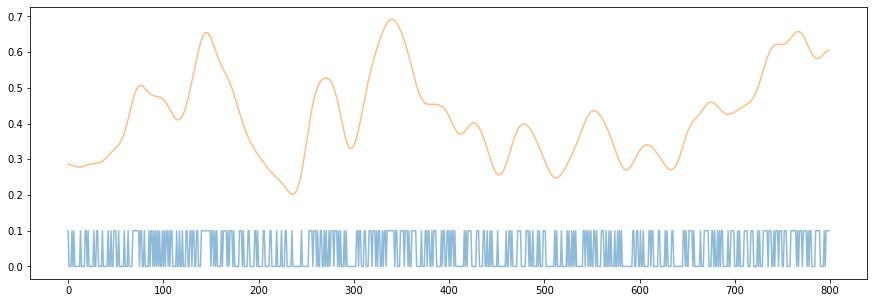

In [186]:
y = X_clf[400:1200,0,top_mi[1]]
plt.figure(figsize=(15,5))
plt.plot(.1*y,alpha=0.5)
plt.plot(gaussian_filter1d(y,10),alpha=0.5)
plt.show()

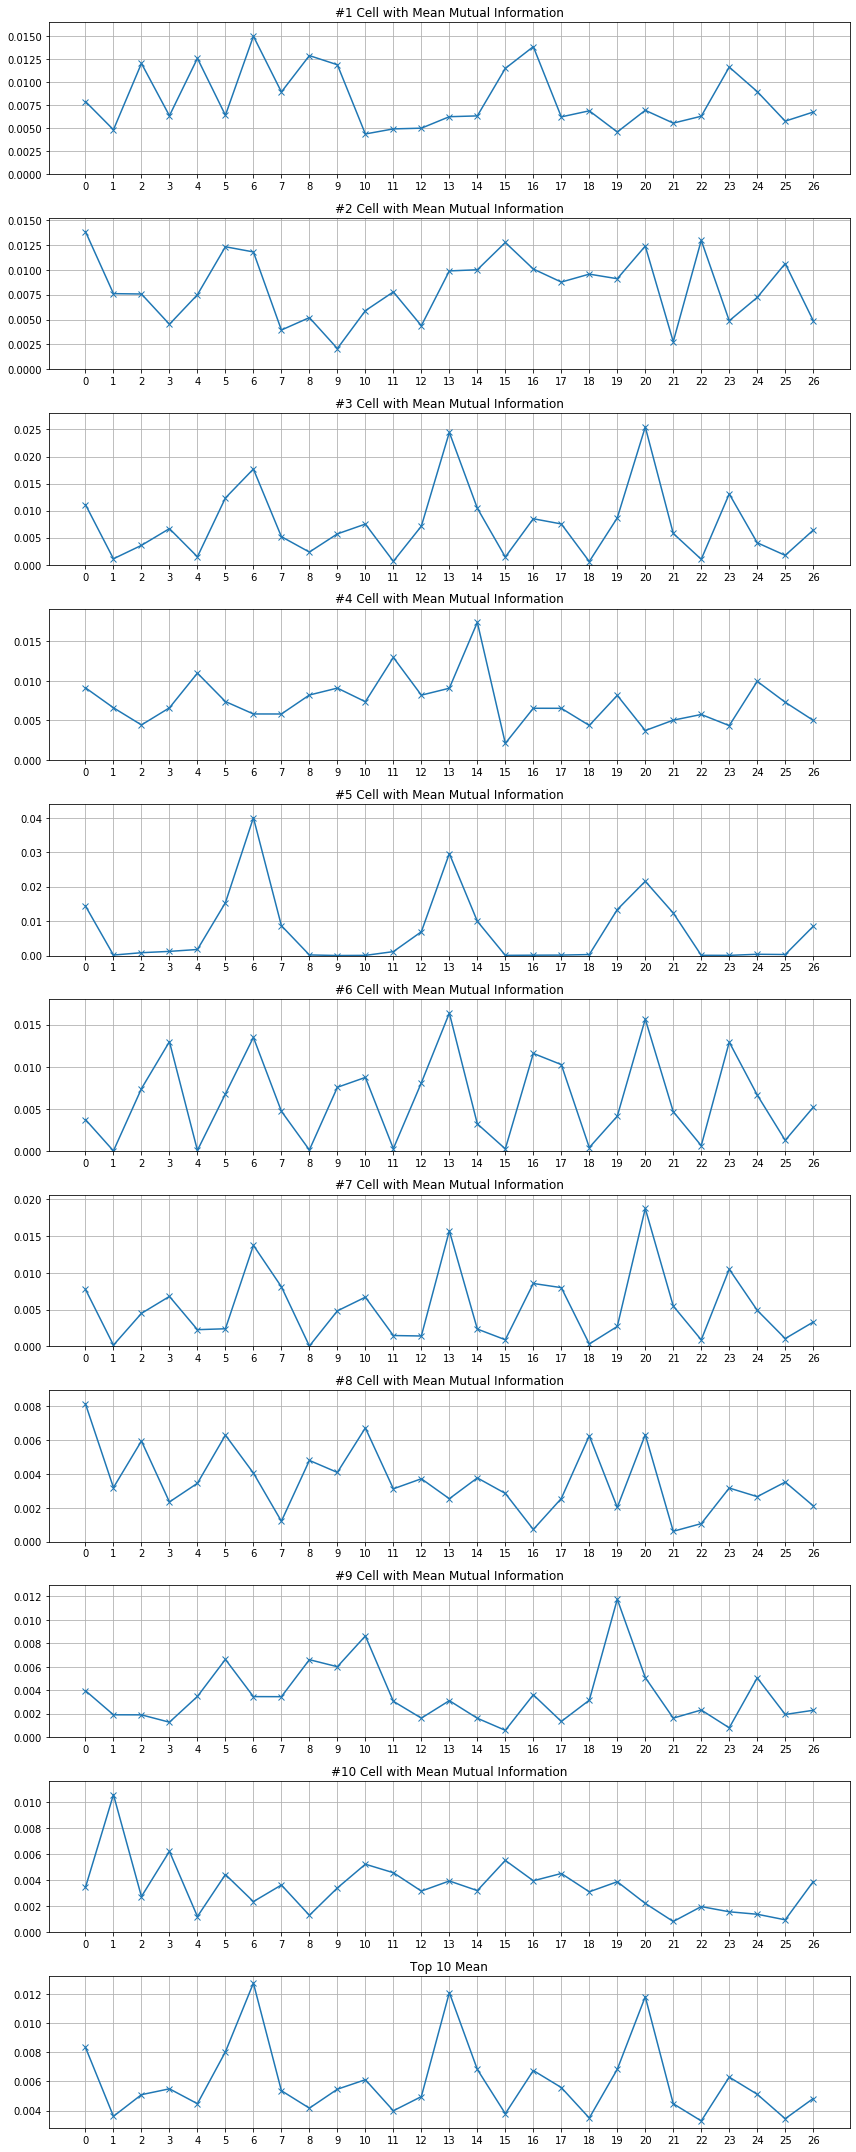

In [187]:
n = 10
step = 1
f,ax = plt.subplots(nrows=n+1,ncols=1)
f.set_figheight(3*n)
f.set_figwidth(12)
for i in range(n):
    y = mis_t[:,top_mi[i]]
    ax[i].set_title(f"#{i+1} Cell with Mean Mutual Information")
    ax[i].plot(y,marker="x")
    ax[i].set_xticks(np.arange(0,len(y),step))
    ax[i].grid(True)
    ax[i].set_ylim(0,1.1*np.max(y))
# mean plot

ax[n].set_title(f"Top {n} Mean")
y = mis_t[:,top_mi[:n]].mean(1)

ax[n].plot(y,marker="x")
ax[n].set_xticks(np.arange(0,len(y),step))
ax[n].grid(True)
plt.tight_layout()
plt.show()    

In [190]:
X_mi_t = np.expand_dims(mis_t,axis=1)

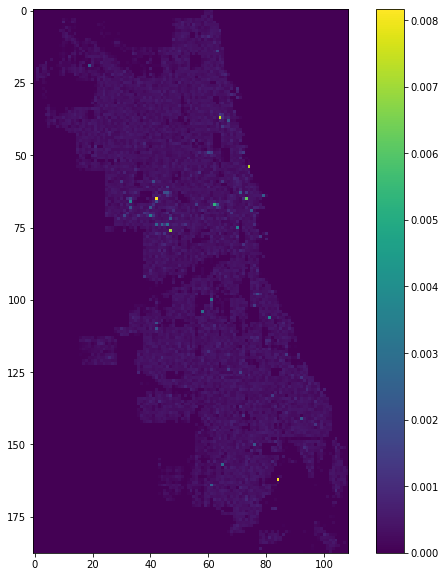

In [199]:
y = shaper.unsqueeze(X_mi_t).mean(0)[0]
im(y)

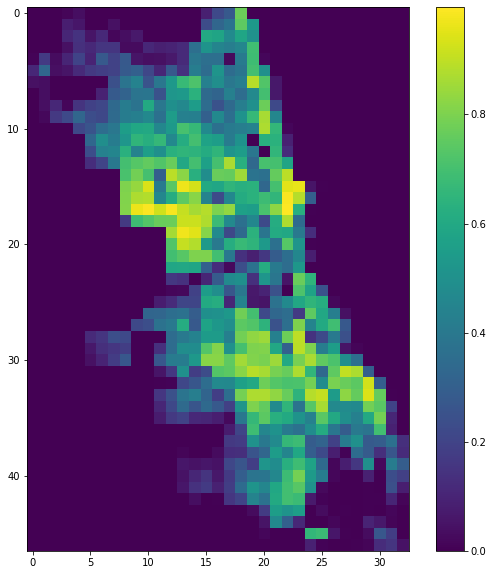

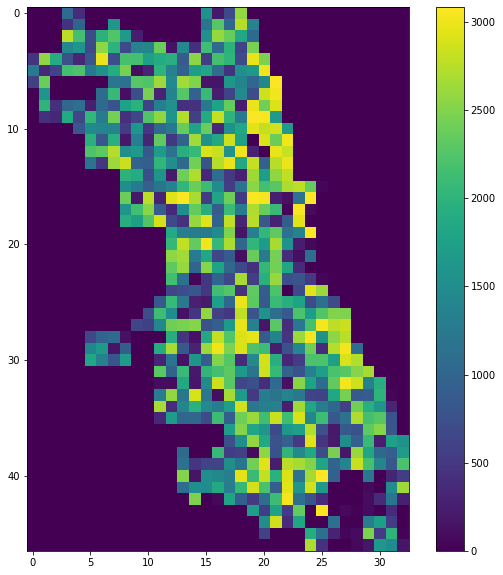

In [145]:
im(shaper.unsqueeze(X_clf).mean(0)[0])
for i in range(1):
    top_mi = np.argsort(mis_t.mean(0))[::-1][:]
    X_top_mi = np.zeros_like(X_clf)
    X_top_mi[:,0,top_mi] = np.arange(len(top_mi))[::-1]
    im(shaper.unsqueeze(4*X_top_mi+X_clf).mean(0)[0])

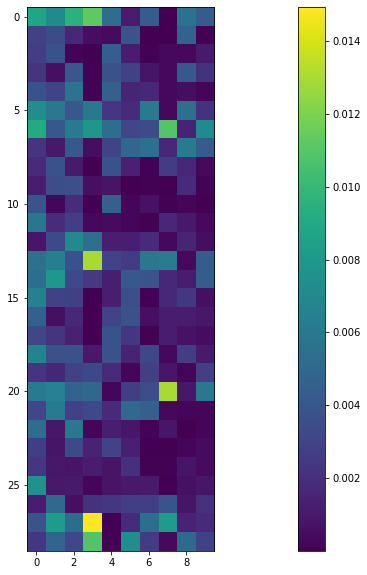

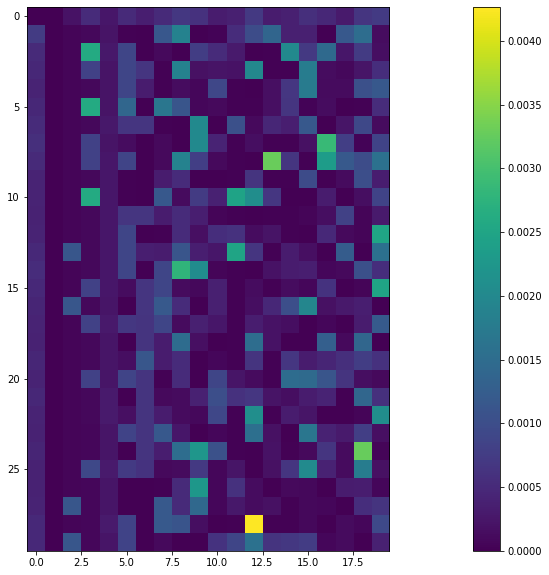

In [226]:
im(mis_t[:,top_mi],figsize=(30, 10),aspect=1)
im(new_mis_grid[:,:20],figsize=(30, 10),aspect=1)

In [63]:
def norm_sum(x):
    return x/np.sum(x)

def norm_max(x):
    return x/np.max(x)

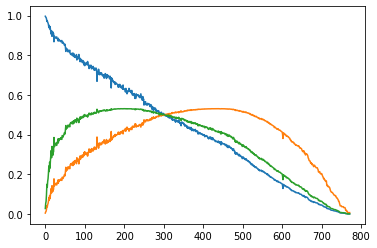

In [65]:
xx = X_clf.mean(0)[0][sorted_indices]

def entropy(x):
    return x*(-1)*np.log2(x)

plt.plot(xx)
plt.plot(entropy(xx))
plt.plot(entropy(1-xx))


In [66]:
X = np.reshape(X_ha[:-1].flatten(),(-1,1))
y = X_clf[1:].flatten()

mutual_info_classif(X,y,discrete_features=True)

array([0.11736102])

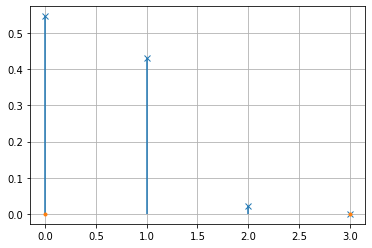

{'dist': {0.0: 0.546478635815175,
          1.0: 0.43147047341897937,
          2.0: 0.021440485485130244,
          3.0: 0.0006104052807154518},
 'max': 3.0,
 'mean': 0.47618266023138617,
 'median': 0.0,
 'min': 0.0,
 'nunique': 4,
 'shape': (1127120, 1),
 'std': 0.5440368893566866}
____________________________________________________________


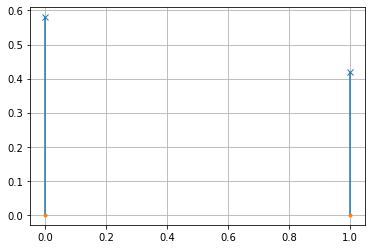

{'dist': {0.0: 0.5800970615373696, 1.0: 0.41990293846263044},
 'max': 1.0,
 'mean': 0.41990293846263044,
 'median': 0.0,
 'min': 0.0,
 'nunique': 2,
 'shape': (1127120,),
 'std': 0.49354276484726106}
____________________________________________________________


In [67]:
describe(X,y)

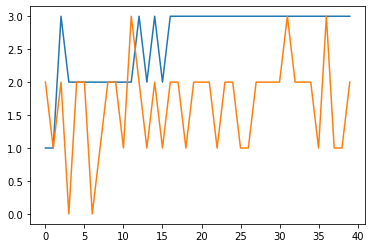

In [68]:
lim = 40
n = 30


plt.plot(1+X_ha[:lim,0,sorted_indices[n]])
plt.plot(X_reg[:lim,0,sorted_indices[n]])

fitted historic average: step (1) and max_steps (-1)


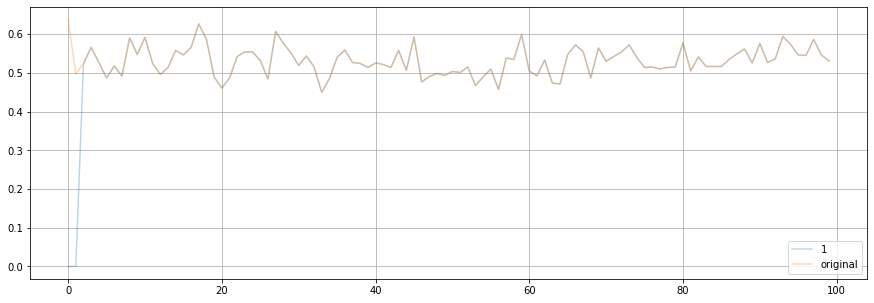

In [182]:
# historic average
ha = HistoricAverage(max_steps=7)
ha.fit(X_reg)

lim = 100

plt.figure(figsize=(15,5))

for max_steps in [1]:
    ha.max_steps = max_steps
    X_ha = ha.transform(X_reg)
    plt.plot(X_ha.mean(-1)[:lim],alpha=0.3,label=f"{max_steps}")

plt.plot(X_reg.mean(-1)[:lim],alpha=0.3,label="original")
plt.grid()
plt.legend()
plt.show()

In [185]:
np.sum(X_reg[10:]-X_ha[10:])



0.0

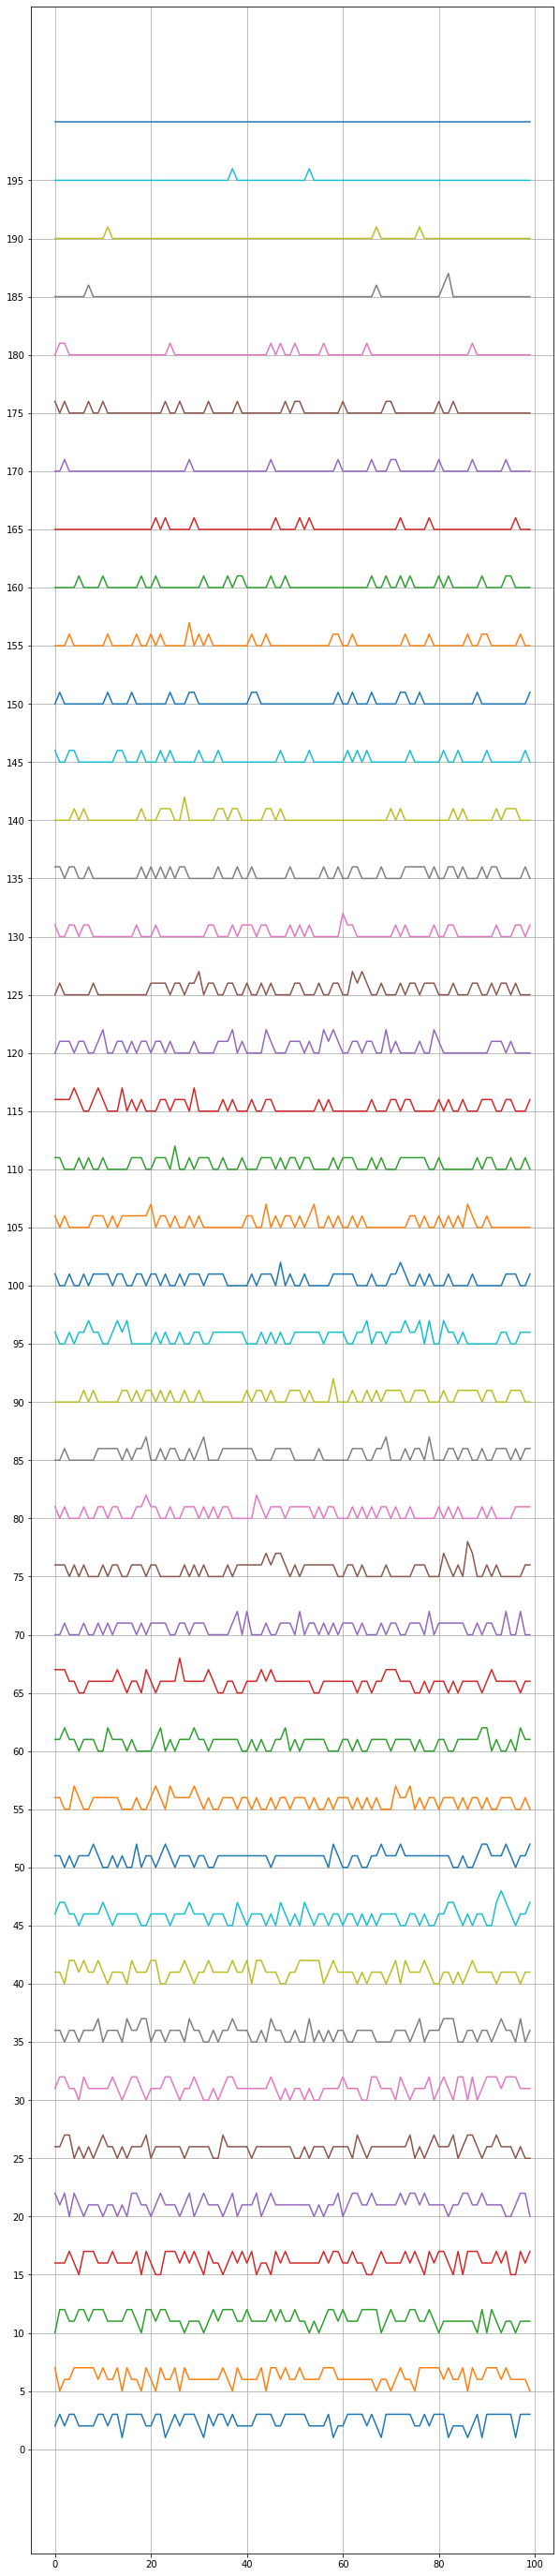

In [35]:
# construct X and y for the mi calculations
max_offset = np.max(X_reg)

plt.figure(figsize=(10,50))
for offset, index in enumerate(sorted_indices[::len(sorted_indices)//40]):
    x = X_reg[:100,0,index]
    plt.plot(x+offset*max_offset)
plt.yticks(np.arange(offset)*max_offset)    
plt.grid()
plt.show()


In [37]:
# shaper can filer out dead cells based on the variance?
conf.data_path

'./data/processed/T24H-X850M-Y880M_2013-01-01_2017-01-01/'

In [87]:
def plot_seq(a):
    plt.figure(figsize=(15,5))
    plt.plot(a)
    plt.grid()
    plt.show()

In [193]:
X_stack = []
y_stack = []

for i in sorted_indices[:]:#range(len(sorted_indices)):
    seq = X_reg[:,0,i]

    seq_len = 100

    sequences = sequencify(seq,seq_len=seq_len+1)  # shape -> (N-seq_len, seq_len)
    X, y = sequences[:,:], np.copy(sequences[:,-1])
    # add al zero column
    n_samples,n_feats = X.shape
    new_X = np.zeros((n_samples,n_feats+2))
    new_X[:, 2:] = X
    new_X[:, 0] = np.random.randint(0, len(set(X.flatten())), size=len(X))

    X = new_X
    y[y > 0] = 1
    
    X_stack.append(X)
    y_stack.append(np.reshape(y,(-1,1)))
    
X = np.vstack(X_stack)
y = np.vstack(y_stack)[:,0]    

In [194]:
pshape(X,y)
mi = mutual_info_classif(X,y,discrete_features=True)
# mi = mutual_info_regression(X,y)
mi = mi/np.max(mi)

(1041428, 103)
(1041428,)


./data/processed/T24H-X850M-Y880M_2013-01-01_2017-01-01/


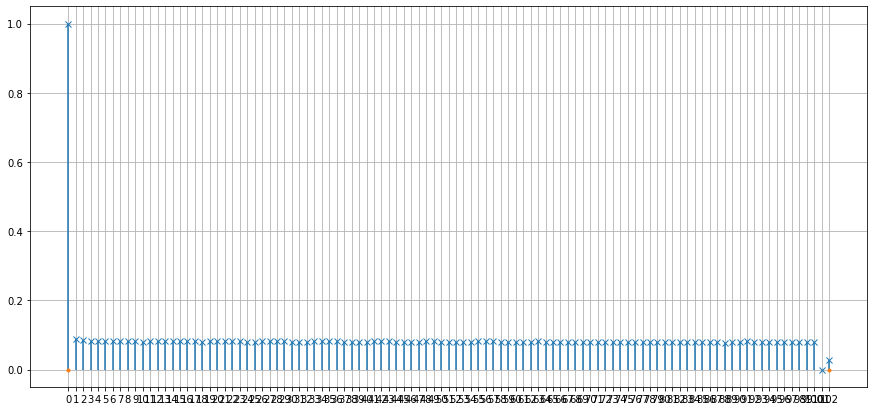

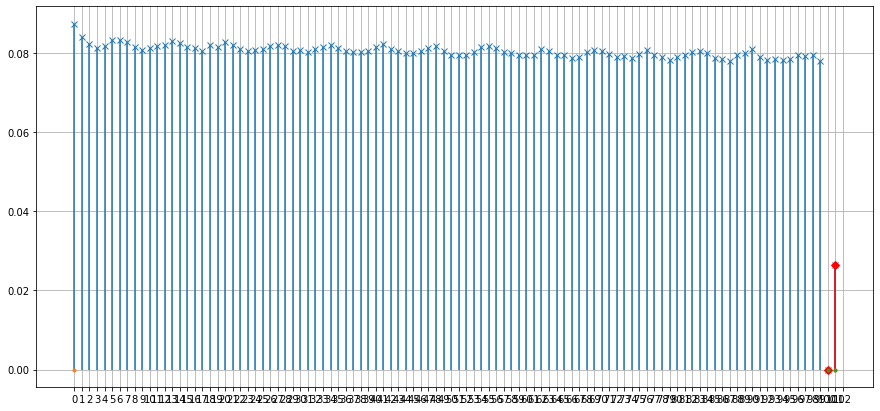

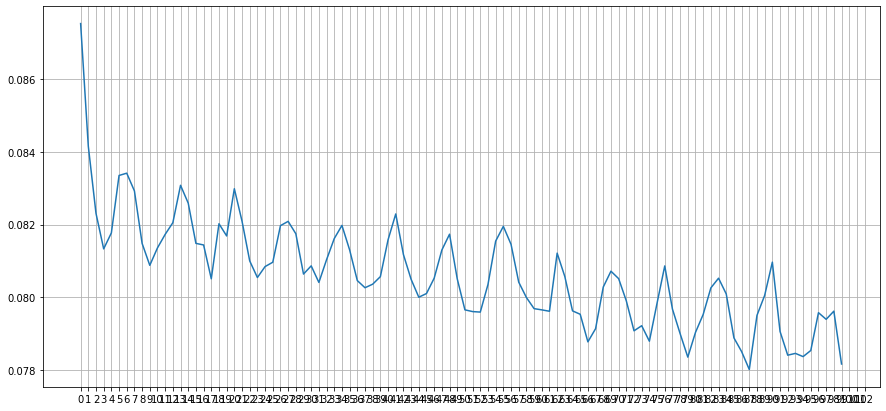

In [195]:
print(conf.data_path)

plt.figure(figsize=(15,7))
plt.stem(mi[::-1], use_line_collection=True,markerfmt="x",basefmt=".")
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()

plt.figure(figsize=(15,7))
plt.stem(mi[:-1][::-1], use_line_collection=True,markerfmt="x",basefmt=".")
plt.stem([len(mi)-3,len(mi)-2],mi[:-1][::-1][-2:], use_line_collection=True,linefmt="r",markerfmt="rD",basefmt=".")
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()

print()
plt.figure(figsize=(15,7))
plt.plot(mi[2:-1][::-1])
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()


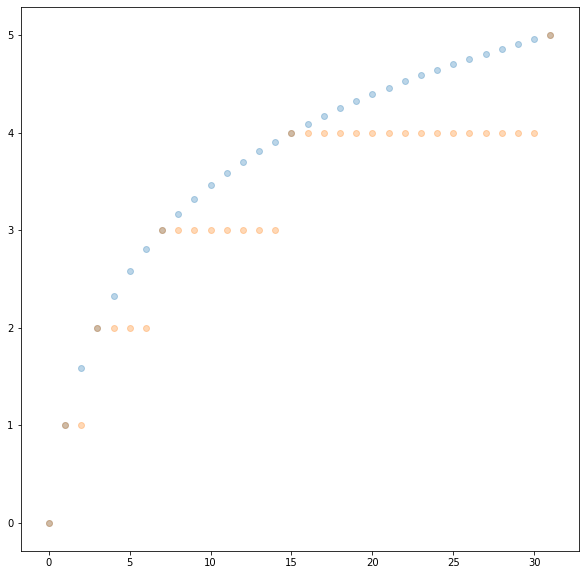

In [104]:

x = np.arange(32)
x_log = np.log2(1 + x)
x_log_round = np.floor(x_log)

plt.figure(figsize=(10,10))
# plt.scatter(x,x,alpha=.3,label="x")
plt.scatter(x,x_log,alpha=.3,label="log(x)")
plt.scatter(x,x_log_round,alpha=.3,label="round(log(x))")
plt.show()
